# Non stationary Ornstein Uhlenbeck in 1D (Fokker-Planck Equation): joint estimation (vanilla)

Consider the following PDE
$$
-\frac{\partial}{\partial x}\left[(\alpha(\mu - x))u(t,x)\right]+
\frac{\partial^2}{\partial x^2}\left[\frac{\sigma^2}{2}u(t,x)\right] =
\frac{\partial}{\partial t}u(t,x)
 $$
 This PDE describes the probability density function of the Orstein-Uhlenbeck process defined as

$$
    \frac{{\mathrm d}}{{\mathrm d}t}X_t=(\alpha(\mu - X_t)) + \sigma\Gamma
$$
where $\Gamma$ is an independent standard Gaussian noise.

In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\nu$. To do so we follow the methodology straightforward methodology from _Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations_, Raissi et al., 2019, i.e., we minimize the dynamic loss with respect to both the neural network parameters and the equation parameters. We also make use of a batch of available observations. See more explanation at [this page](https://hgangloff.pages.mia.inra.fr/pinn_experiments/param_estim_pinn.html)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

/home/hugo/anaconda3/envs/pinn2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import other dependencies

In [5]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

## Observations
We use artificial observations from the estimated solution in the other Ornstein-Uhlenbeck 1D notebook.

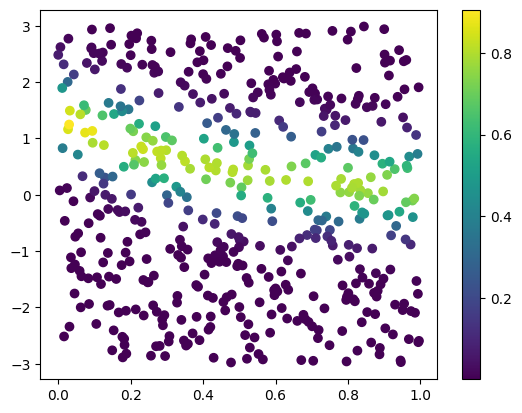

In [6]:
observations = jnp.load("OU_1D_nonstatio_solution_grid.npy")
key, subkey = jax.random.split(key)
size_subsample = 500
time_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[0], 1),
    shape=(size_subsample,),
    replace=False
)
key, subkey = jax.random.split(key)
size_subsample = 500
omega_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[1], 1),
    shape=(size_subsample,),
    replace=False
)
obs_batch = observations[
    time_subsample,
    omega_subsample
]

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

__Optionally blur the observed values__

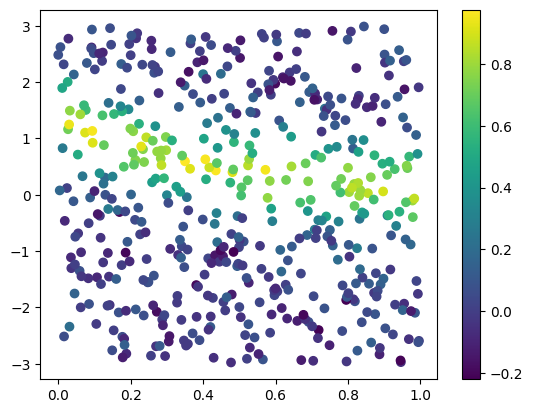

In [7]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] +
    random.normal(subkey, obs_batch[:, 2].shape) * 0.1
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [8]:
eqx_list = [
    [eqx.nn.Linear, 2, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [9]:
init_nn_params = init_param_fn()

Create a DataGenerator object

In [10]:
n = 1000
nb = 2
nt = 1000
omega_batch_size = 32
temporal_batch_size = 20
omega_border_batch_size = 2
dim = 1
xmin = -3
xmax = 3
tmin = 0
tmax = 1
Tmax = 5
key, subkey = random.split(key)

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax
)

Initialize the PINN parameters and visualize the PINN output before training

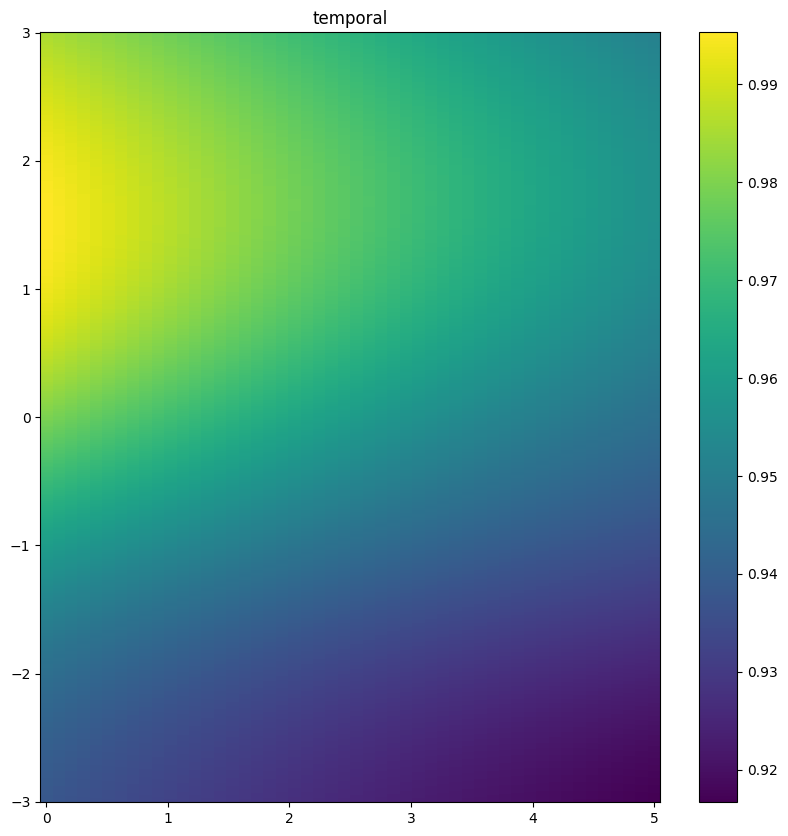

In [11]:
u_init = partial(u, u_params=init_nn_params)

nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

jinns.data.plot1d_image(u_init, xdata=val_xdata, times=val_times, cmap="viridis", Tmax=Tmax, colorbar=True, figsize=(10,10), title="temporal")

## Model parameters

__Optionally blur the initial parameter value__

In [12]:
# True:
sigma_true = 0.5 * jnp.ones((1))
alpha_true = .5 * jnp.ones((1))
mu_true = jnp.zeros((1))
key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
sigma = sigma_true + random.normal(subkey2, shape=(1,)) * 0.05
alpha = alpha_true + random.normal(subkey1, shape=(1,)) * 0.05
mu = mu_true + random.normal(subkey3, shape=(1,)) * 0.05
print(sigma, alpha, mu)

[0.4923365] [0.5331581] [0.06505276]


In our problem we know the analytical stationary solution

In [13]:
from jax.scipy.stats import norm

def u_statio(x):
    return norm.pdf(x, loc=0, scale=sigma/jnp.sqrt(2*alpha))[0] # output a scalar
vectorized_u_statio = vmap(u_statio, (0), 0)

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary


In [14]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "sigma":sigma,
        "alpha":alpha,
        "mu":mu
    }
}

## Set up the initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

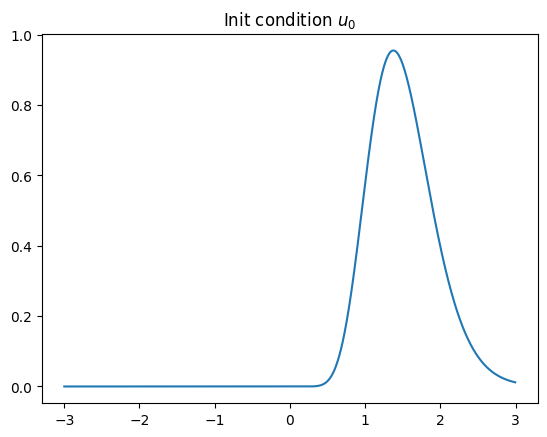

In [15]:
# Init to the stationary solution
#u0 = u_statio

# Another init
# # true solution N(0,1)
# sigma_init = 1 * jnp.ones((1))
# alpha_init = .25 * jnp.ones((1))
# mu_init = 2 * jnp.ones((1))
# @jit
# def u0(x):
#     return norm.pdf(x, loc=mu_init, scale=sigma_init/jnp.sqrt(2*alpha_init))[0] # output a scalar

# Yet another init
init_alphas = {"1": 1.5, "2": 1, "3": 0.5}

def u0(x):
    # Gamma pdf implemented in jax.scipy
    shape = (2 * init_alphas["1"]) / init_alphas["3"] ** 2
    scale =  init_alphas["3"] ** 2 / (2 * init_alphas["2"])
    return jax.scipy.stats.gamma.pdf(x, a = shape, scale = scale)[0]

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Loss construction

We decide to provide the set of points upon which the normalization constant will be computed

In [16]:
int_xmin, int_xmax = -5, 5
n_samples = int(500)
int_length = int_xmax - int_xmin
key, subkey = random.split(key)
mc_samples = random.uniform(subkey, shape = (n_samples, 1), minval=int_xmin, maxval=int_xmax) 

__Note: An important thing to note in the next cell is the derivative argument set to "both". This means that we will differentiate the Dynamic Loss both with respect to nn_params and eq_params.__

In [17]:
OU_fpe_non_statio_1D_loss = jinns.loss.OU_FPENonStatioLoss1D(Tmax=Tmax, derivatives="both")

In [18]:
loss_weights = {"dyn_loss":1, "norm_loss":0.001 * Tmax, "temporal_loss":0.1 * Tmax, "observations":1}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_1D_loss,
    temporal_boundary_fun=u0,
    norm_key=None,
    norm_borders=(int_xmin, int_xmax),
    norm_samples=mc_samples,
    obs_batch=[obs_batch[:, 0], obs_batch[:, 1], obs_batch[:, 2]]
)

/home/hugo/Documents/recherche/pinn/pinn_study/Notebooks/PDE/../../jinns/loss/_LossPDE.py:286: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [19]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 8.02
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '6.64', 'norm_loss': '72.46', 'observations': '0.69', 'temporal_loss': '0.67'}


## Joint estimation of `eq_params` and `nn_params`

In [20]:
params = init_params

In [21]:
# Optimizer
import optax
from jaxopt import OptaxSolver

In [22]:
n_iter = int(50000)

Here we alternate between optimizing `nn_params` and `eq_params` by using "opposite schedulers" in `optax`. We provide a utility function `alternate_optax_solver` which performs the alternating optimization.

In [23]:
# steps at which learning alternates between the two sets of params (excluding step 0 !)
steps = np.arange(1000, n_iter, 1000) # NOTE this is a numpy array !
tx = jinns.utils.alternate_optax_solver(steps, ["nn_params"], ["alpha", "sigma", "mu"], 1e-3, 1e-5)

Next consists in classical initializations

In [24]:
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output
                     maxiter=50000)

In [25]:
pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter,
)

Next we define which parameter we want to track

In [26]:
accu_vars = [
    ['eq_params', 'alpha'],
    ['eq_params', 'sigma'],
    ['eq_params', 'mu'],
]

In [27]:
key, subkey = random.split(key, 2)
params, total_loss_list, loss_by_term_dict, _, accu_vars_params = pinn_solver.solve(
    init_params=params,
    data=train_data,
    accu_vars=accu_vars
)

Running for 50,000 iterations: 100%|█████| 50000/50000 [07:38<00:00, 109.17it/s]


## Results

Plot the tracked parameters

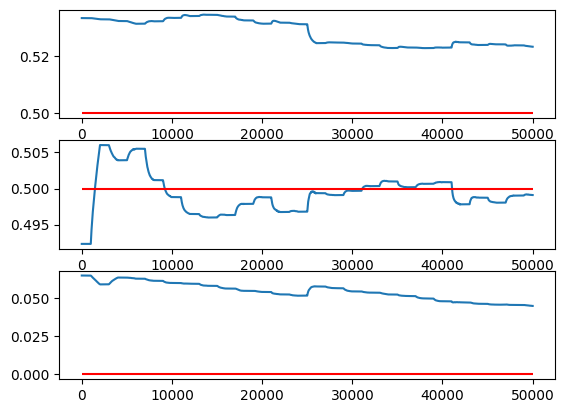

In [28]:
fig, axes = plt.subplots(3)
true_values = [alpha_true, sigma_true, mu_true]
for i, params_path in enumerate(accu_vars):
    axes[i].plot(accu_vars_params['-'.join(map(str, params_path))], label=params_path[-1])
    axes[i].hlines(y=true_values[i], xmin=0, xmax=n_iter, color="r")
plt.show()

Plot the loss values

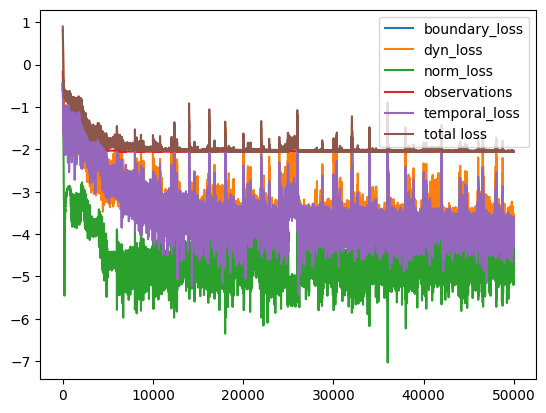

In [29]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

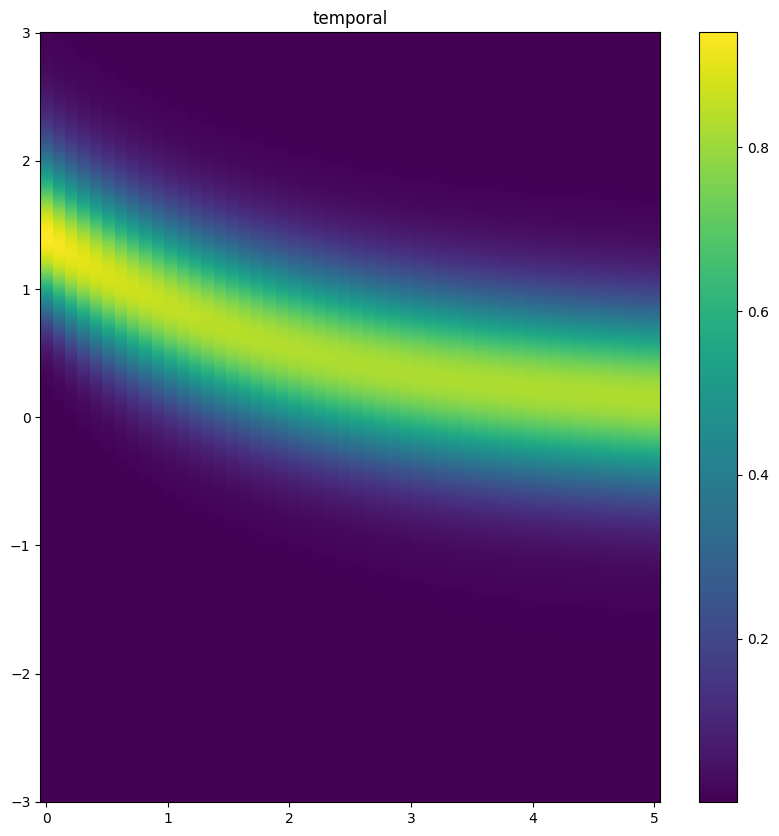

In [31]:
u_est = vmap(partial(u, u_params=params["nn_params"]), (0), 0)

u_est = partial(u, u_params=params["nn_params"])

jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", Tmax=Tmax, colorbar=True, figsize=(10,10), title="temporal")

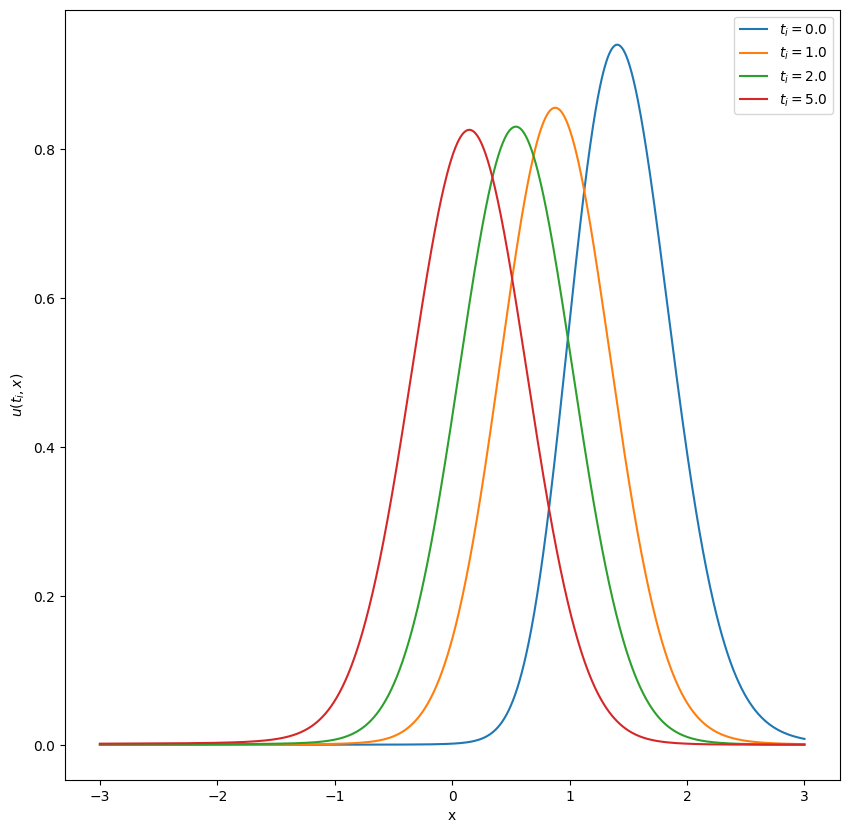

In [33]:
time_slices = jnp.array([0, 0.2, 0.4, 1])
jinns.data.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax)

## Comparison with the true stationary solution

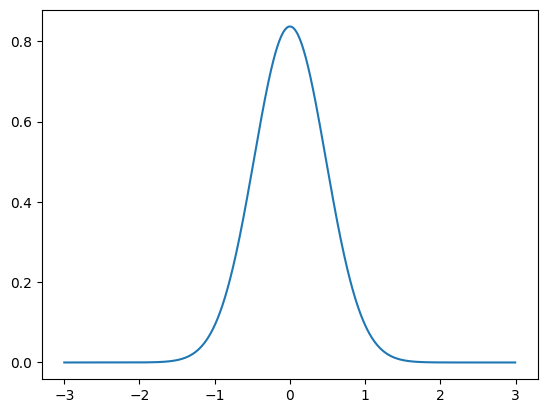

In [34]:
plt.plot(test_data.omega.sort(axis=0), vectorized_u_statio(test_data.omega.sort(axis=0)))
plt.show()